# Power Outages Prediction

### Winter 2020


# Summary of Findings

### Introduction
The dataset comes from the link https://www.sciencedirect.com/science/article/pii/S2352340918307182 and it contains major power outage events within the US from January 2000 to July 2016. 

We are interested in this dataset because outages cause disruption to everyone’s lives and it is worthy to study them. Since most of the column names are abbreviated,  we first used the data dictionary to understand what the columns represent. Moreover, the data set consists of 55 variables and over 1.5k observations; the data spans over 16 years. The dataset contains data of the date/time,region,price of electricity, population, and etc of the outages that occured.

To our surprise, this dataset is pertinent to our prediction question of “Predict the total customers affected by an outage” because it contains a myriad of relevant information such as ‘year’, ‘location’, ‘climate region’, and other socioeconomic data such as GDP/population density. Thus, based on the data richness of this dataset, we can narrow down our prediction question to build a robust algorithm to predict accurately the total customers affected by  

This problem will be a classification problem becuase we will try to predict if the number of customers affected by an outage was greater than or less than the mean of the customers affect. The target variable will be the customers affected columns in the dataset, which is represented by the total amount of customers affected by the outage.

### Baseline Model

For our baseline model, we decided to do the most simple things to get a result. When we chose the columns, we thought about the columns that would have the most inpact on our outcome column, customers affected. The process behind the selection was not done through anything special, but merely just using common sense and thinking which columns would be correlated with each other.

Before we put our values in, we decided to do some model cleaning in order to take in account for the null values in the dataset. We decided not to drop any null values because the rows could have columns that have values that would effect the outcome of our machine learning model. For most of the quantitative value columns we simply imputed them with the mean or median values in order to keep the distribution of the column near the center, but this could possibly lead to errors later on in the model. We decided with the mean and median because we did not want to increase variance and biases into the dataset

For our categorical columns, we decided to use one hot encoding so that the string values can be associated by some integer in order for the machine learning model to run. 

In addition to those executions performed on the dataset, we decided to binarize some columns. The columns are mostly the ones after performing data imputation on the null values. Doing this would remove all noise from the model because everything would be binarized, so outliers will not have an effect on our model.

After running the the model, our accuracy for our baseline is around 59%. This was done with the the Support Vector Machine Classifier and no hyperparamter tuning. The classification algoirthm was just chosen at random, and because we thought it would perform the best of all the classifiers.

### Final Model
After our horrible performance on our baseline model, we wanted design a better pipeline for our machine learning model. We brainstormed ideas on what columns to add, what feature engineering to perform, and what classifiers we could possibly use to improve our final score. 

The first thing we did was to included the time and date columns, since we figure that they may play a huge factor into how many people are affected. For instance, if the the outage occurs at midnight, when majority of people are sleeping, then the total number of affected will be lower compared to an outage that occurs during mid-day. We binarized most of the quantitative column for simplicity, but we will consider scaling them as derived features for our improved model. So we decided to do some feature engineering. We converted the 'OUTAGE.START.DATE' and 'OUTAGEE.START.TIME' to pd.Timestamps objects, then we used the .weekday() and .hour() functions to extract the weekday and hour of the outage. 

The first thing we did was to standardize the 'OUTAGE.START.DATE', 'OUTAGE.START.TIME', and 'OUTAGE.DURATION". We decided to do this because we wanted to make them be on the same comparison scale. We also decided to Log-scale the  TOTAL.CUSTOMERS column. We decided to this because we didnt want our column to have a huge skew and in a sense bring the extreme values closer to the distirbution of values.

For our classifer, we decided to use Decision Trees. After running many classifers, the decision tree gave us the highest score of all the other classifiers. All other colunmns and process were kept the same.

The final accuracy score we got was over 88%. This is roughly 30% improvement in accuracy from our baseline model. This was due to the change of classification algorithm and adding feature engineering to our dataset.

### Fairness Evaluation

We decided to split our data by 'TOTAL.PRICE' into two groups. Namely, we used the median of the 'TOTAL.PRICE" as a threshold and consequently labeled data points that are below the median as 'cheap' and 'expensive' otherwise. We are particularly interested in this business ethical question after conducting a mini EDA since we saw that the recall scores across the price ranges in the dataset look fairly equal.  We wanted to use a permutation test to figure out if our model will be biased to perform better for more 'expensive' electricity. 

The performance metrics we chose for our fairness evaluation are F1 score and recall score. We refrained from using simply the accuracy score because it doesn’t portray a full picture of the imbalance in data. Thus, we chose to use recall, or True Positive Rate, and F1, which is harmonic mean of recall and specificity to judge the fairness of our model.

We shuffled the price labels using a permutation tests and our null hypothesis is that our test statistic, which is the difference in recall and F1 score, come from the same distribution. Using a 5% significance level, our p values > 0.05. We fail to reject our null hypothesis, which infers that our model is fair in determining the total customers affected across both cheap and expensive avg. electricity price.  

# Code

In [1]:
# import data cleaning packages
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
# import raw data
raw = pd.read_csv('outage.csv')
raw.set_index('OBS').head(1)
raw.head()

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
NaN,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",5:00:00 PM,"Sunday, July 3, 2011",8:00:00 PM,severe weather,NaN,NaN,3060.0,NaN,70000.0,11.60,9.18,6.81,9.28,2332915.0,2114774.0,2113291.0,6562520.0,35.549073,32.225029,32.202431,2308736,276286,10673,2595696,88.9448,10.6440,0.4112,51268,47586,1.077376,1.6,4802,274182,1.751391,2.2,5348119,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
NaN,2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",6:38:00 PM,"Sunday, May 11, 2014",6:39:00 PM,intentional attack,vandalism,NaN,1.0,NaN,NaN,12.12,9.71,6.49,9.28,1586986.0,1807756.0,1887927.0,5284231.0,30.032487,34.210389,35.727564,2345860,284978,9898,2640737,88.8335,10.7916,0.3748,53499,49091,1.089792,1.9,5226,291955,1.790002,2.2,5457125,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
NaN,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,"Tuesday, October 26, 2010",8:00:00 PM,"Thursday, October 28, 2010",10:00:00 PM,severe weather,heavy wind,NaN,3000.0,NaN,70000.0,10.87,8.19,6.07,8.15,1467293.0,1801683.0,1951295.0,5222116.0,28.097672,34.501015,37.365983,2300291,276463,10150,2586905,88.9206,10.6870,0.3924,50447,47287,1.066826,2.7,4571,267895,1.706266,2.1,5310903,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
NaN,4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Tuesday, June 19, 2012",4:30:00 AM,"Wednesday, June 20, 2012",11:00:00 PM,severe weather,thunderstorm,NaN,2550.0,NaN,68200.0,11.79,9.25,6.71,9.19,1851519.0,1941174.0,1993026.0,5787064.0,31.994099,33.543330,34.439329,2317336,278466,11010,2606813,88.8954,10.6822,0.4224,51598,48156,1.071476,0.6,5364,277627,1.932089,2.2,5380443,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
NaN,5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,"Saturday, July 18, 2015",2:00:00 AM,"Sunday, July 19, 2015",7:00:00 AM,severe weather,NaN,NaN,1740.0,250.0,250000.0,13.07,10.16,7.74,10.43,2028875.0,2161612.0,1777937.0,5970339.0,33.982576,36.205850,29.779498,2374674,289044,9812,2673531,88.8216,10.8113,0.3670,54431,49844,1.092027,1.7,4873,292023,1.668704,2.2,5489594,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


# Choosing columns that are relevant for our baseline model

In [3]:
df = pd.read_csv('outage.csv',usecols = ['OBS','U.S._STATE','CLIMATE.CATEGORY','TOTAL.PRICE',
                                        'TOTAL.CUSTOMERS','YEAR','MONTH',
                                        'CAUSE.CATEGORY','DEMAND.LOSS.MW',
                                        'CAUSE.CATEGORY','OUTAGE.DURATION','OUTAGE.DURATION',
                                        'CUSTOMERS.AFFECTED','POPDEN_URBAN','PC.REALGSP.CHANGE','PCT_WATER_INLAND'
                                         ,'IND.CUST.PCT'])
df = df.set_index('OBS')
df.head()

,YEAR,MONTH,U.S._STATE,CLIMATE.CATEGORY,CAUSE.CATEGORY,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,TOTAL.PRICE,TOTAL.CUSTOMERS,IND.CUST.PCT,PC.REALGSP.CHANGE,POPDEN_URBAN,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,normal,severe weather,3060.0,NaN,70000.0,9.28,2595696,0.4112,1.6,2279.0,5.478743
2,2014,5.0,Minnesota,normal,intentional attack,1.0,NaN,NaN,9.28,2640737,0.3748,1.9,2279.0,5.478743
3,2010,10.0,Minnesota,cold,severe weather,3000.0,NaN,70000.0,8.15,2586905,0.3924,2.7,2279.0,5.478743
4,2012,6.0,Minnesota,normal,severe weather,2550.0,NaN,68200.0,9.19,2606813,0.4224,0.6,2279.0,5.478743
5,2015,7.0,Minnesota,warm,severe weather,1740.0,250.0,250000.0,10.43,2673531,0.3670,1.7,2279.0,5.478743


## Cleaning our data and filling NaNs

In [4]:
# Simple imputing 
df['CUSTOMERS.AFFECTED'] = df['CUSTOMERS.AFFECTED'].fillna(0)
df['TOTAL.PRICE'] = df['TOTAL.PRICE'].fillna(df['TOTAL.PRICE'].mean())
df['MONTH'] = df['MONTH'].fillna(df['MONTH'].median())
df['OUTAGE.DURATION'] = df['OUTAGE.DURATION'].fillna(0)
df['DEMAND.LOSS.MW'] = df['DEMAND.LOSS.MW'].fillna(0)
df['CLIMATE.CATEGORY'] = df['CLIMATE.CATEGORY'].fillna(df['CLIMATE.CATEGORY'].mode()[0])

# Binarize column for simplicity
mean_dur = df['OUTAGE.DURATION'].median()
df['OUTAGE.DURATION'] = df['OUTAGE.DURATION'].apply(lambda x : 1 if x > mean_dur  else 0)

mean_price = df['TOTAL.PRICE'].median()
df['TOTAL.PRICE'] = df['TOTAL.PRICE'].apply(lambda x : 1 if x > mean_price else 0)

mean_cust = df['TOTAL.CUSTOMERS'].median()
df['TOTAL.CUSTOMERS'] = df['TOTAL.CUSTOMERS'].apply(lambda x : 1 if x > mean_cust else 0)

mean_gdp = df['PC.REALGSP.CHANGE'].mean()
df['PC.REALGSP.CHANGE'] = df['PC.REALGSP.CHANGE'].apply(lambda x : 1 if x > mean_gdp else 0)

mean_ind = df['IND.CUST.PCT'].median()
df['IND.CUST.PCT'] = df['IND.CUST.PCT'].apply(lambda x : 1 if x > mean_ind  else 0)

# Binarize predictor
mean_affected = df['CUSTOMERS.AFFECTED'].median()
df['CUSTOMERS.AFFECTED'] = df['CUSTOMERS.AFFECTED'].apply(lambda x : 1 if x > mean_affected  else 0)

df

,YEAR,MONTH,U.S._STATE,CLIMATE.CATEGORY,CAUSE.CATEGORY,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,TOTAL.PRICE,TOTAL.CUSTOMERS,IND.CUST.PCT,PC.REALGSP.CHANGE,POPDEN_URBAN,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,normal,severe weather,1,0.0,1,0,0,0,1,2279.0,5.478743
2,2014,5.0,Minnesota,normal,intentional attack,0,0.0,0,0,0,0,1,2279.0,5.478743
3,2010,10.0,Minnesota,cold,severe weather,1,0.0,1,0,0,0,1,2279.0,5.478743
4,2012,6.0,Minnesota,normal,severe weather,1,0.0,1,0,0,0,0,2279.0,5.478743
5,2015,7.0,Minnesota,warm,severe weather,1,250.0,1,1,0,0,1,2279.0,5.478743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,cold,public appeal,1,155.0,1,0,0,1,1,2192.2,2.401765
1531,2006,6.0,North Dakota,normal,fuel supply emergency,0,1650.0,0,1,0,1,1,2192.2,2.401765
1532,2009,8.0,South Dakota,warm,islanding,0,84.0,0,0,0,1,0,2038.3,1.692256


## Import sklearn packages

In [5]:
# import Function transformer packages
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import OrdinalEncoder

# import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# import model selection packages
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# import performance metric packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# Part I. Building our baseline model

In [6]:
display(df.head())
display(df.shape)

,YEAR,MONTH,U.S._STATE,CLIMATE.CATEGORY,CAUSE.CATEGORY,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,TOTAL.PRICE,TOTAL.CUSTOMERS,IND.CUST.PCT,PC.REALGSP.CHANGE,POPDEN_URBAN,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,normal,severe weather,1,0.0,1,0,0,0,1,2279.0,5.478743
2,2014,5.0,Minnesota,normal,intentional attack,0,0.0,0,0,0,0,1,2279.0,5.478743
3,2010,10.0,Minnesota,cold,severe weather,1,0.0,1,0,0,0,1,2279.0,5.478743
4,2012,6.0,Minnesota,normal,severe weather,1,0.0,1,0,0,0,0,2279.0,5.478743
5,2015,7.0,Minnesota,warm,severe weather,1,250.0,1,1,0,0,1,2279.0,5.478743


(1534, 14)

In [7]:
def baseline_model(df):
    X = df.drop('CUSTOMERS.AFFECTED',axis=1)
    y = df['CUSTOMERS.AFFECTED']
    
    hot1 = ['U.S._STATE']
    hot3 = ['CLIMATE.CATEGORY']
    hot4 = ['CAUSE.CATEGORY']
    std = ['DEMAND.LOSS.MW']
    
    preproc = ColumnTransformer(transformers = [('hot',OneHotEncoder(handle_unknown = 'ignore'),hot1),
                                                ('hot3',OneHotEncoder(handle_unknown = 'ignore'),hot3),
                                                ('hot4',OneHotEncoder(handle_unknown = 'ignore'),hot4)]
                                ,remainder = 'passthrough')
    pl = Pipeline(steps = [('preprocessor',preproc),('regressor', svm.SVC())])
    pl.fit(X,y)
    return pl

## Evaluating our baseline model

In [8]:
acc = []
f1 = []
recall = []
specificity = []

for i in range(10):
    X = df.drop('CUSTOMERS.AFFECTED',axis=1)
    y = df['CUSTOMERS.AFFECTED']
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20)
    train = X_train.join(y_train)
    score = baseline_model(train)
    
    preds = score.predict(X_test)
    preds1 = accuracy_score(y_test, preds)
    acc.append(preds1)
    
    preds2 = f1_score(y_test, preds, average='weighted')
    f1.append(preds2)
    
    preds3 = recall_score(y_test, preds, average=None)
    recall.append(preds3)
    
    preds4 = recall_score(y_test, preds, average=None, pos_label=0)
    specificity.append(preds4)
    
print("Accuracy of baseline model is: " + str(np.mean(acc)))
print("Recall of baseline model is: " + str(np.mean(recall)))
print("Specificity of baseline model is: " + str(np.mean(specificity)))
print("F1 score of baseline model is: " + str(np.mean(f1)))

/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: N

Accuracy of baseline model is: 0.5941368078175896
Recall of baseline model is: 0.5962257668493396
Specificity of baseline model is: 0.5962257668493396
F1 score of baseline model is: 0.5484943011804115


/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


## Improving our baseline model

1. We decided to included the time and date columns, since we figure that they may play a huge factor into how many people are affected. For instance, if the the outage occurs at midnight, when majority of people are sleeping, then the total number of affected will be lower compared to an outage that occurs during mid-day. 


2. In our base model, we binarized most of the quantitative column for simplicity, but we will consider scaling them as derived features for our improved model. 

In [9]:
df = pd.read_csv('outage.csv',usecols = ['OBS','U.S._STATE','CLIMATE.CATEGORY','TOTAL.PRICE',
                                        'TOTAL.CUSTOMERS','YEAR','MONTH',
                                        'DEMAND.LOSS.MW',
                                         'OUTAGE.START.DATE',
                                         'OUTAGE.START.TIME',
                                         'CAUSE.CATEGORY','OUTAGE.DURATION',
                                        'CUSTOMERS.AFFECTED','POPDEN_URBAN','PC.REALGSP.CHANGE','PCT_WATER_INLAND'
                                         ,'IND.CUST.PCT'])
df = df.set_index('OBS')
df.head()

,YEAR,MONTH,U.S._STATE,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,CAUSE.CATEGORY,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,TOTAL.PRICE,TOTAL.CUSTOMERS,IND.CUST.PCT,PC.REALGSP.CHANGE,POPDEN_URBAN,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,normal,"Friday, July 1, 2011",5:00:00 PM,severe weather,3060.0,NaN,70000.0,9.28,2595696,0.4112,1.6,2279.0,5.478743
2,2014,5.0,Minnesota,normal,"Sunday, May 11, 2014",6:38:00 PM,intentional attack,1.0,NaN,NaN,9.28,2640737,0.3748,1.9,2279.0,5.478743
3,2010,10.0,Minnesota,cold,"Tuesday, October 26, 2010",8:00:00 PM,severe weather,3000.0,NaN,70000.0,8.15,2586905,0.3924,2.7,2279.0,5.478743
4,2012,6.0,Minnesota,normal,"Tuesday, June 19, 2012",4:30:00 AM,severe weather,2550.0,NaN,68200.0,9.19,2606813,0.4224,0.6,2279.0,5.478743
5,2015,7.0,Minnesota,warm,"Saturday, July 18, 2015",2:00:00 AM,severe weather,1740.0,250.0,250000.0,10.43,2673531,0.3670,1.7,2279.0,5.478743


In [10]:
# # Data imputing, c/p from above to clean 
df['CUSTOMERS.AFFECTED'] = df['CUSTOMERS.AFFECTED'].fillna(0)
df['TOTAL.PRICE'] = df['TOTAL.PRICE'].fillna(df['TOTAL.PRICE'].mean())
df['MONTH'] = df['MONTH'].fillna(df['MONTH'].median())
df['OUTAGE.DURATION'] = df['OUTAGE.DURATION'].fillna(df['OUTAGE.DURATION'].median())
df['DEMAND.LOSS.MW'] = df['DEMAND.LOSS.MW'].fillna(0)
df['CLIMATE.CATEGORY'] = df['CLIMATE.CATEGORY'].fillna(df['CLIMATE.CATEGORY'].mode()[0])

# Binarize column for simplicity
mean_dur = df['OUTAGE.DURATION'].median()
df['OUTAGE.DURATION'] = df['OUTAGE.DURATION'].apply(lambda x : 1 if x > mean_dur  else 0)

# mean_price = df['TOTAL.PRICE'].median()
# df['TOTAL.PRICE'] = df['TOTAL.PRICE'].apply(lambda x : 1 if x > mean_price else 0)

mean_cust = df['TOTAL.CUSTOMERS'].median()
df['TOTAL.CUSTOMERS'] = df['TOTAL.CUSTOMERS'].apply(lambda x : 1 if x > mean_cust else 0)

mean_gdp = df['PC.REALGSP.CHANGE'].mean()
df['PC.REALGSP.CHANGE'] = df['PC.REALGSP.CHANGE'].apply(lambda x : 1 if x > mean_gdp else 0)

mean_ind = df['IND.CUST.PCT'].median()
df['IND.CUST.PCT'] = df['IND.CUST.PCT'].apply(lambda x : 1 if x > mean_ind  else 0)

# Binarize predictor
mean_affected = df['CUSTOMERS.AFFECTED'].median()
df['CUSTOMERS.AFFECTED'] = df['CUSTOMERS.AFFECTED'].apply(lambda x : 1 if x > mean_affected else 0)

df

,YEAR,MONTH,U.S._STATE,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,CAUSE.CATEGORY,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,TOTAL.PRICE,TOTAL.CUSTOMERS,IND.CUST.PCT,PC.REALGSP.CHANGE,POPDEN_URBAN,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,normal,"Friday, July 1, 2011",5:00:00 PM,severe weather,1,0.0,1,9.280000,0,0,1,2279.0,5.478743
2,2014,5.0,Minnesota,normal,"Sunday, May 11, 2014",6:38:00 PM,intentional attack,0,0.0,0,9.280000,0,0,1,2279.0,5.478743
3,2010,10.0,Minnesota,cold,"Tuesday, October 26, 2010",8:00:00 PM,severe weather,1,0.0,1,8.150000,0,0,1,2279.0,5.478743
4,2012,6.0,Minnesota,normal,"Tuesday, June 19, 2012",4:30:00 AM,severe weather,1,0.0,1,9.190000,0,0,0,2279.0,5.478743
5,2015,7.0,Minnesota,warm,"Saturday, July 18, 2015",2:00:00 AM,severe weather,1,250.0,1,10.430000,0,0,1,2279.0,5.478743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,cold,"Tuesday, December 6, 2011",8:00:00 AM,public appeal,1,155.0,1,7.560000,0,1,1,2192.2,2.401765
1531,2006,6.0,North Dakota,normal,NaN,NaN,fuel supply emergency,0,1650.0,0,10.117851,0,1,1,2192.2,2.401765
1532,2009,8.0,South Dakota,warm,"Saturday, August 29, 2009",10:54:00 PM,islanding,0,84.0,0,7.670000,0,1,0,2038.3,1.692256


### Transform date, time into weekday and hour 

In [11]:
# change to day/hour 
df['OUTAGE.START.DATE'] = df['OUTAGE.START.DATE'].apply(lambda x:pd.Timestamp(x).weekday()+1)
df['OUTAGE.START.TIME'] = df['OUTAGE.START.TIME'].apply(lambda x:pd.Timestamp(x).hour)

# Impute the missing weekday and hour with their respective modes
df['OUTAGE.START.TIME'] = df['OUTAGE.START.TIME'].fillna(df['OUTAGE.START.TIME'].mode()[0])
df['OUTAGE.START.DATE'] = df['OUTAGE.START.DATE'].fillna(df['OUTAGE.START.DATE'].mode()[0])

## Derived features: 

1. Standard Scaling 'Weekday' and 'Hour' and 'OUTAGE.DURATION"
2. Log-scaling TOTAL.CUSTOMERS

In [12]:
def final_model(df):
    X = df.drop('CUSTOMERS.AFFECTED',axis=1)
    y = df['CUSTOMERS.AFFECTED']
    
    scaleCol = ['OUTAGE.START.DATE','OUTAGE.START.TIME','PC.REALGSP.CHANGE','OUTAGE.DURATION']
    hot1 = ['U.S._STATE']
    hot3 = ['CLIMATE.CATEGORY']
    hot4 = ['CAUSE.CATEGORY']
    std = ['DEMAND.LOSS.MW']
    
    preproc = ColumnTransformer(transformers = [
                                                ('logdur',FunctionTransformer(np.log1p),['TOTAL.CUSTOMERS']), # log scale
                                                ('std',StandardScaler(),scaleCol), # standard scale
                                                ('hot',OneHotEncoder(handle_unknown = 'ignore'),hot1),
                                                ('hot3',OneHotEncoder(handle_unknown = 'ignore'),hot3),
                                                ('hot4',OneHotEncoder(handle_unknown = 'ignore'),hot4)]
                                ,remainder = 'passthrough')
    pl = Pipeline(steps = [('preprocessor',preproc),('regressor',DecisionTreeClassifier())])
    pl.fit(X,y)
    return pl

## Evaluating our final model

In [13]:
acc = []
f1 = []
recall = []
specificity = []

for i in range(50):
    X = df.drop('CUSTOMERS.AFFECTED',axis=1)
    y = df['CUSTOMERS.AFFECTED']
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20)
    train = X_train.join(y_train)
    score = final_model(train)
    
    preds = score.predict(X_test)
    preds1 = accuracy_score(y_test, preds)
    acc.append(preds1)
    
    preds2 = f1_score(y_test, preds, average='weighted')
    f1.append(preds2)
    
    preds3 = recall_score(y_test, preds, average=None)
    recall.append(preds3)
    
    preds4 = recall_score(y_test, preds, average=None, pos_label=0)
    specificity.append(preds4)
    
print("Accuracy of baseline model is: " + str(np.mean(acc)))
print("Recall of baseline model is: " + str(np.mean(recall)))
print("Specificity of baseline model is: " + str(np.mean(specificity)))
print("F1 score of baseline model is: " + str(np.mean(f1)))

/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: N

/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: N

Accuracy of baseline model is: 0.8909446254071662
Recall of baseline model is: 0.8908663630144195
Specificity of baseline model is: 0.8908663630144195
F1 score of baseline model is: 0.890925839494869


/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Users/Samuel1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: N

We got roughly 30% improvement across all our performance metrics in our final model

# Fairness Evaluations & Parity measures


## Is this model more fair for expensive/cheap total average monthly electricity price?

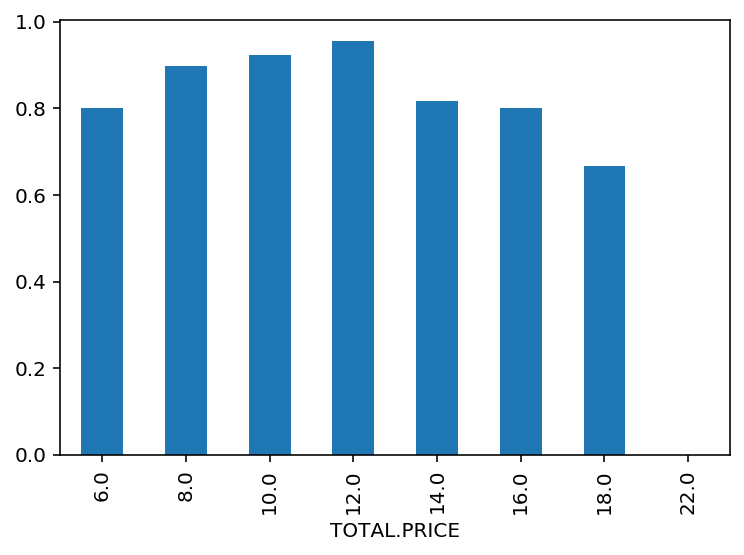

In [1940]:
results = X_test
results['TOTAL.PRICE'] = results['TOTAL.PRICE'].apply(lambda x:2*(x//2 + 1))
results['prediction'] = preds 
results['actual_test'] = y_test
(
    results
    .groupby('TOTAL.PRICE')
    .apply(lambda x:f1_score(x['actual_test'], x.prediction))
    .plot(kind='bar')
)

## Calculate Parity Measures 

### Is this difference in f1 score significant?

In [1941]:
medianPrice = results['TOTAL.PRICE'].median()

results['TOTAL.PRICE'] = (results['TOTAL.PRICE'] <= medianPrice).replace({True:'cheap',False:
                                                                         'expensive'})

In [1942]:
obs = results.groupby('TOTAL.PRICE').apply(lambda x: f1_score(x['actual_test'], x.prediction)).diff().iloc[-1]

metrs = []
for _ in range(100):
    s = (
        results[['TOTAL.PRICE', 'prediction', 'actual_test']]
        .assign(test=results['TOTAL.PRICE'].sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('test')
        .apply(lambda x: f1_score(x.actual_test, x.prediction))
        .diff()
        .iloc[-1]
    )
    metrs.append(s)


In [1943]:
print(pd.Series(metrs <= obs).mean())

0.38


### Are the scores significantly different in terms of recall parity?

* Recall: proportion of appropriately predicted numbers of customers afected across price category.


In [1944]:
(
    results
    .groupby('TOTAL.PRICE')
    .apply(lambda x:recall_score(x['actual_test'], x.prediction)).rename('recall').to_frame()
    
)

,recall
TOTAL.PRICE,
cheap,0.887640
expensive,0.910714


In [1945]:
obs = results.groupby('TOTAL.PRICE').apply(lambda x: recall_score(x['actual_test'], x.prediction)).diff().iloc[-1]

metrs = []
for _ in range(100):
    s = (
        results[['TOTAL.PRICE', 'prediction', 'actual_test']]
        .assign(test=results['TOTAL.PRICE'].sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('test')
        .apply(lambda x: recall_score(x.actual_test, x.prediction))
        .diff()
        .iloc[-1]
    )
    metrs.append(s)

In [1946]:
print(pd.Series(metrs <= obs).mean())

0.73
